# Linjär Regressionsanalys av Bostadspriser i Kalifornien

## Introduktion
I denna laboration analyseras datasetet *California Housing* med hjälp av multipel linjär regression (OLS).
Datasetet innehåller **20 640 observationer** och beskriver bostadsområden i Kalifornien med variabler som
medianinkomst, husålder, antal rum, befolkning, geografisk position samt närheten till havet.

**Responsvariabel (Y):** `median_house_value` — medianvärdet på bostäder inom ett område.

**Syfte:** Bygga en OLS-modell från grunden (utan sklearn) för att:
1. Skatta regressionsparametrarna (β) och tolka deras betydelse.
2. Bedöma modellens övergripande förklaringsgrad (R², justerat R², F-test).
3. Testa individuella koefficienter (t-test, konfidensintervall).
4. Undersöka multikollinearitet via Pearson-korrelation.
5. Utvärdera modellens antaganden genom residualdiagnostik.

## Metod
Modellen implementeras i en egen klass (`LinearRegression` i `linear_regression.py`) som enbart använder **numpy** och **scipy.stats** — inga ML-bibliotek.

**Steg i analysen:**
1. **Datainläsning** — CSV-filen läses in och konverteras till numeriska arrayer.
2. **Saknade värden** — Kolumnen `total_bedrooms` har 207 saknade värden. Dessa imputeras med kolumnmedelvärdet så att alla 20 640 observationer kan användas.
3. **Kategorisk kodning** — `ocean_proximity` one-hot-kodas med *drop-first* (referenskategori `<1H OCEAN`) för att undvika perfekt multikollinearitet med interceptet.
4. **Modellskattning** — OLS via normalequationen: $\hat{\beta} = (X^TX)^{-1}X^Ty$ (med pseudoinvers för numerisk stabilitet).
5. **Inferens** — t-test, F-test, konfidensintervall, Pearson-korrelation.
6. **Diagnostik** — Residualanalys (residualer vs. predikterade, histogram) och jämförelse av predikterade mot faktiska värden.

In [ ]:
import numpy as np
import csv
from scipy.stats import normaltest
from linear_regression import LinearRegression

## 1. Datainläsning och förbehandling
Datasetet läses in från `housing.csv`. Numeriska kolumner konverteras till `float`, tomma celler tolkas som `NaN` och imputeras med respektive kolumnmedelvärde. Den kategoriska variabeln `ocean_proximity` sparas separat.

In [ ]:
path = 'housing.csv'
with open(path, newline='', encoding='utf-8') as f:
    r = csv.DictReader(f)
    rows = list(r)
cols_num = [
    'longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
    'population','households','median_income'
]
y_col = 'median_house_value'
cat_col = 'ocean_proximity'

n = len(rows)
X_num = np.empty((n, len(cols_num)), dtype=float)
y = np.empty(n, dtype=float)
cat = np.empty(n, dtype=object)
for i, row in enumerate(rows):
    for j, c in enumerate(cols_num):
        v = row[c]
        X_num[i, j] = float(v) if v != '' else np.nan
    y[i] = float(row[y_col])
    cat[i] = row[cat_col]

missing_before = {c: int(np.isnan(X_num[:, j]).sum()) for j, c in enumerate(cols_num)}

col_means = np.nanmean(X_num, axis=0)
inds = np.where(np.isnan(X_num))
X_num[inds] = np.take(col_means, inds[1])

{
    'observationer': n,
    'numeriska_sardrag': len(cols_num),
    'kategorisk_variabel': cat_col,
    'responsvariabel': y_col,
    'saknade_varden_fore_imputering': {k: v for k, v in missing_before.items() if v > 0},
    'imputering': 'kolumnmedelvarde'
}

Saknade värden per kolumn (före imputering):
  total_bedrooms: 207

Antal observationer: 20640
Numeriska särdrag:  8
Kategorisk variabel: ocean_proximity
Responsvariabel:    median_house_value
Imputering klar — alla NaN ersatta med kolumnmedelvärde.


## 2. Explorativ dataanalys (EDA)
Nedan undersöks datasetet: deskriptiv statistik för de numeriska variablerna, fördelning av den kategoriska variabeln, samt en snabb kontroll av variabelernas spridning.

In [ ]:
all_cols = cols_num + [y_col]
all_data = np.column_stack([X_num, y])

descriptive = {}
for j, name in enumerate(all_cols):
    col = all_data[:, j]
    descriptive[name] = {
        'min': round(float(np.min(col)), 2),
        'medel': round(float(np.mean(col)), 2),
        'median': round(float(np.median(col)), 2),
        'max': round(float(np.max(col)), 2),
        'std': round(float(np.std(col)), 2),
    }

ocean_categories, ocean_counts = np.unique(cat.astype(str), return_counts=True)
kategori_fordelning = {c: int(cnt) for c, cnt in zip(ocean_categories, ocean_counts)}

{
    'deskriptiv_statistik': descriptive,
    'ocean_proximity_fordelning': kategori_fordelning,
}

Variabel                           Min        Medel       Median          Max          Std
-------------------------------------------------------------------------------------
longitude                      -124.35      -119.57      -118.49      -114.31         2.00
latitude                         32.54        35.63        34.26        41.95         2.14
housing_median_age                1.00        28.64        29.00        52.00        12.59
total_rooms                       2.00      2635.76      2127.00     39320.00      2181.56
total_bedrooms                    1.00       537.87       438.00      6445.00       419.26
population                        3.00      1425.48      1166.00     35682.00      1132.43
households                        1.00       499.54       409.00      6082.00       382.32
median_income                     0.50         3.87         3.53        15.00         1.90
median_house_value            14999.00    206855.82    179700.00    500001.00    115392.82

OBS

### Diskussion kring särdragsval (Feature Selection)
Baserat på utforskningen av datasetet har jag valt att inkludera samtliga tillgängliga särdrag i modellen.

1. **Kategorisk data:** Särdraget `ocean_proximity` one-hot-kodas med *drop-first* — kategorin `<1H OCEAN` blir referensnivå. Detta undviker perfekt multikollinearitet med interceptet (dummy-variabelfällan).

2. **Multikollinearitet:** Det finns starka korrelationer mellan `total_rooms`, `total_bedrooms`, `population` och `households` (r > 0.85). Trots detta behåller jag samtliga särdrag för att kunna analysera deras individuella signifikans. Modellen använder pseudoinvers (`np.linalg.pinv`) för numerisk stabilitet vid (nära-)singulära matriser.

3. **Censurering:** `median_house_value` är capped vid 500 001 — detta bryter mot OLS-antagandet om linjäritet i svansarna och påverkar residualstrukturen i övre prisintervallet.

## 3. Modellskattning
Designmatrisen byggs genom att kombinera de 8 numeriska särdragen med de one-hot-kodade dummy-variablerna (4 st, efter drop-first). Interceptet läggs till automatiskt av `LinearRegression`-klassen, vilket ger totalt **13 kolumner** i designmatrisen (1 intercept + 8 numeriska + 4 dummies).

In [ ]:
model = LinearRegression(confidence_level=0.95, add_intercept=True, drop_first_category=True)
X_cat, categories = model.one_hot_encode(cat, drop_first=model.drop_first_category)
X = np.column_stack([X_num, X_cat])
feature_names = cols_num + [f'{cat_col}={c}' for c in categories]
model.fit(X, y, feature_names=feature_names)

{
    'feature_names': feature_names,
    'antal_sardrag (d)': model.d,
    'antal_observationer (n)': model.n,
}

(['longitude', 'latitude', 'housing_median_age'], 12, 20640, 12)

## 4. Felmetrik (Error Metrics)
Nedan beräknas de grundläggande felmåtten: variansen för residualerna ($s^2$), residualernas standardavvikelse (Residual Standard Error) samt RMSE.

In [ ]:
{
    'varians (s²)': model.variance(),
    'standardavvikelse (s)': model.standard_deviation(),
    'RMSE': model.rmse(),
}

Varians (s²)              4,723,656,867.17
Residual Std Error        68,728.86
RMSE                      68,707.22

Tolkning: I genomsnitt avviker modellens prediktioner med ca $68,707 från faktiskt medianhusvärde.


## 5. Övergripande modellrelevans och signifikans
F-testet prövar nollhypotesen att alla koefficienter (utom interceptet) är noll. R² anger andelen av variansen i Y som förklaras av modellen.

In [ ]:
{
    'R²': model.r2(),
    'justerat_R²': model.adjusted_r2(),
    'F-test': model.f_test(),
}

R²:              0.6455
Justerat R²:     0.6453
F-statistika:    3129.59  (df1=12, df2=20627)
p-värde (F):     0

Tolkning: Modellen förklarar 64.5% av variansen i median_house_value.
F-testets p-värde ≈ 0 → vi förkastar H₀ att alla koefficienter = 0.
Modellen som helhet är statistiskt signifikant.


## 6. Individuella koefficienttest och konfidensintervall
Tabellen nedan visar varje koefficients skattade värde, standardfel, t-statistika, p-värde samt 95%-konfidensintervall. Signifikansmarkeringar: `*` = p < 0.0001, `.` = p < 0.05.

In [7]:
model.summary()

   / \__
  (    @\___   Regression Rex says:
  /         O  '🤷 MEH... (Better than guessing)'
 /   (_____/
/_____/   U

================================= STATS DUMP =================================
Observations: 20640           R-squared:      0.6455
Features:     12              Adj. R-squared: 0.6453
RMSE:         68707.2172      F-statistic:    3129.5865
Res. Std Err: 68728.8649      Prob (F-stat):  0
------------------------------------------------------------------------------
                                   Coef    Std Err        t    P>|t| [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept *                  -2235716.9130 87495.1155   -25.55   0.0000 -2407214.2514 -2064219.5745
longitude *                  -26458.2894  1014.0350   -26.09   0.0000 -28445.8781 -24470.7007
latitude *                   -25197.1990   999.9078   -25.20   0.0000 -27157.0972 -23237.3008
housing_median_age *          1057.8638    43.7043    24.

## 7. Beroendeanalys (Pearson-korrelation)
Pearson-korrelationsmatrisen beräknas över samtliga särdrag i designmatrisen (exklusive interceptet). Starka korrelationer (|r| > 0.8) indikerar multikollinearitet, vilket kan ge instabila koefficienter och uppblåsta standardfel.

In [ ]:
pearson = model.pearson_pairs(X, include_intercept=False)
r_matrix = pearson['r']

n_feats = len(feature_names)
starka_korrelationer = {}
for i in range(n_feats):
    for j in range(i + 1, n_feats):
        if abs(r_matrix[i, j]) > 0.8:
            starka_korrelationer[f'{feature_names[i]} <-> {feature_names[j]}'] = round(r_matrix[i, j], 3)

{
    'korrelationsmatris': np.round(r_matrix, 2).tolist(),
    'legend': {i: name for i, name in enumerate(feature_names)},
    'starka_korrelationer (|r| > 0.8)': starka_korrelationer,
}

Pearson-korrelationsmatris (12×12):

         0     1     2     3     4     5     6     7     8     9    10    11
 0 |  1.00 -0.92 -0.11  0.04  0.07  0.10  0.06 -0.02 -0.06  0.01 -0.47  0.05
 1 | -0.92  1.00  0.01 -0.04 -0.07 -0.11 -0.07 -0.08  0.35 -0.02  0.36 -0.16
 2 | -0.11  0.01  1.00 -0.36 -0.32 -0.30 -0.30 -0.12 -0.24  0.02  0.26  0.02
 3 |  0.04 -0.04 -0.36  1.00  0.93  0.86  0.92  0.20  0.03 -0.01 -0.02 -0.01
 4 |  0.07 -0.07 -0.32  0.93  1.00  0.87  0.97 -0.01 -0.01 -0.00 -0.02  0.00
 5 |  0.10 -0.11 -0.30  0.86  0.87  1.00  0.91  0.00 -0.02 -0.01 -0.06 -0.02
 6 |  0.06 -0.07 -0.30  0.92  0.97  0.91  1.00  0.01 -0.04 -0.01 -0.01  0.00
 7 | -0.02 -0.08 -0.12  0.20 -0.01  0.00  0.01  1.00 -0.24 -0.01  0.06  0.03
 8 | -0.06  0.35 -0.24  0.03 -0.01 -0.02 -0.04 -0.24  1.00 -0.01 -0.24 -0.26
 9 |  0.01 -0.02  0.02 -0.01 -0.00 -0.01 -0.01 -0.01 -0.01  1.00 -0.01 -0.01
10 | -0.47  0.36  0.26 -0.02 -0.02 -0.06 -0.01  0.06 -0.24 -0.01  1.00 -0.14
11 |  0.05 -0.16  0.02 -0.01  0.00 -0.0

### Tolkning av korrelationsmatrisen
- **longitude ↔ latitude** (r ≈ −0.92): Stark negativ korrelation — förväntad eftersom koordinaterna samvarierar geografiskt.
- **total_rooms ↔ total_bedrooms ↔ households ↔ population** (r ≈ 0.85–0.97): Dessa variabler mäter alla "blockstorlek" och är starkt beroende. I praktiken innebär detta att deras individuella koefficienter kan vara instabila (stora standardfel), men modellens övergripande prediktionsförmåga påverkas inte.
- **median_income** har låg korrelation med övriga variabler (|r| < 0.25), vilket gör den till det mest oberoende och informativa särdraget.

## 8. Jämförelse av konfidensnivåer (95% vs 99%)
Genom att ändra konfidensnivån till 99% breddas konfidensintervallen — färre koefficienter kan vara signifikanta vid strängare krav. Nedan visas den fullständiga sammanfattningen vid 99% konfidensnivå.

In [9]:
model_99 = LinearRegression(confidence_level=0.99, add_intercept=True, drop_first_category=True)
model_99.fit(X, y, feature_names=feature_names)

model_99.summary()

   / \__
  (    @\___   Regression Rex says:
  /         O  '🤷 MEH... (Better than guessing)'
 /   (_____/
/_____/   U

================================= STATS DUMP =================================
Observations: 20640           R-squared:      0.6455
Features:     12              Adj. R-squared: 0.6453
RMSE:         68707.2172      F-statistic:    3129.5865
Res. Std Err: 68728.8649      Prob (F-stat):  0
------------------------------------------------------------------------------
                                   Coef    Std Err        t    P>|t| [99.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept *                  -2235716.9130 87495.1155   -25.55   0.0000 -2461110.2522 -2010323.5738
longitude *                  -26458.2894  1014.0350   -26.09   0.0000 -29070.5122 -23846.0666
latitude *                   -25197.1990   999.9078   -25.20   0.0000 -27773.0290 -22621.3689
housing_median_age *          1057.8638    43.7043    24.

## 9. Predikterade vs. Faktiska värden
Modellens prediktioner ($\hat{y}$) jämförs med de faktiska värdena ($y$). Nedan visas sammanfattande statistik för prediktionsfelet samt en uppdelning per prisintervall.

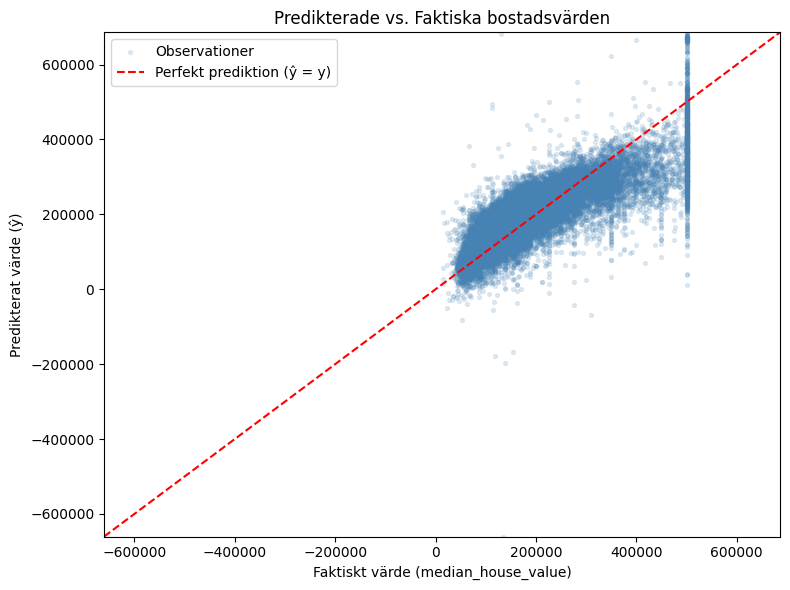

Notera den horisontella klustringen vid y = 500 001 (cap i datasetet).
Modellen underpredikterar systematiskt för de dyraste bostäderna.


In [ ]:
y_pred = model.predict(X)
residuals = model.residuals()

bins = [0, 100000, 200000, 300000, 400000, 500001, np.inf]
labels = ['0-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k+']
pred_vs_actual = {}
for k in range(len(bins) - 1):
    mask = (y >= bins[k]) & (y < bins[k + 1])
    if mask.sum() > 0:
        errors = residuals[mask]
        pred_vs_actual[labels[k]] = {
            'antal': int(mask.sum()),
            'medel_residual': round(float(np.mean(errors)), 2),
            'std_residual': round(float(np.std(errors)), 2),
        }

{
    'prediktionssammanfattning': {
        'medel_predikterat': round(float(np.mean(y_pred)), 2),
        'medel_faktiskt': round(float(np.mean(y)), 2),
        'korrelation_pred_vs_faktiskt': round(float(np.corrcoef(y, y_pred)[0, 1]), 4),
    },
    'residualer_per_prisintervall': pred_vs_actual,
}

## 10. Residualdiagnostik
OLS förutsätter att residualerna ($e = y - \hat{y}$) är approximativt normalfördelade med konstant varians. Nedan undersöks residualernas fördelningsegenskaper numeriskt.

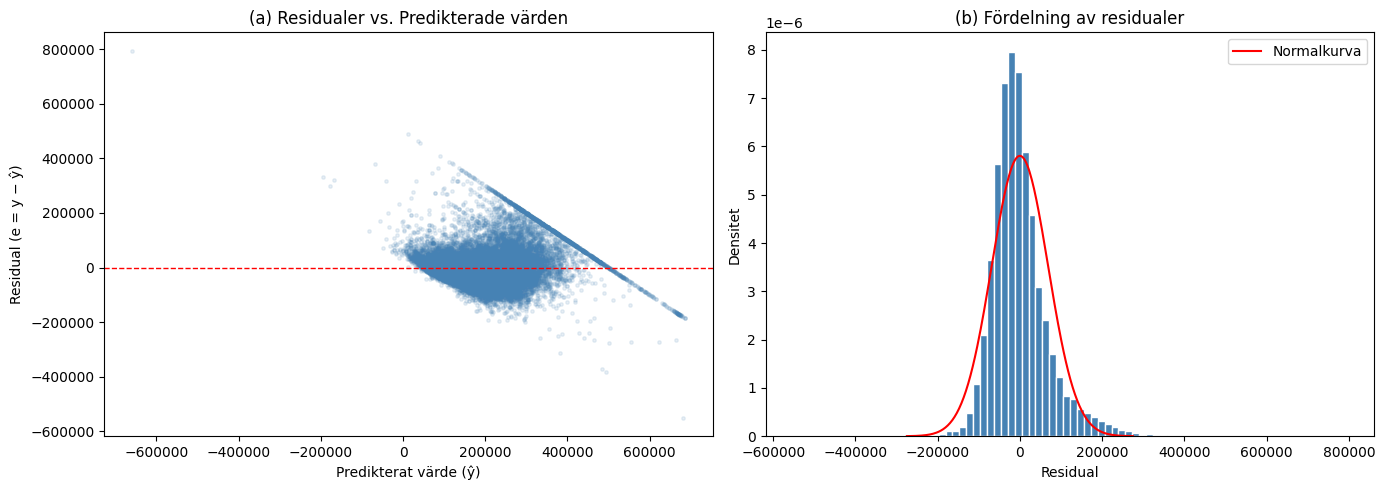

Residualer: medelvärde = -0.00, std = 68707.22

Tolkning:
  (a) Residualerna visar en tydlig trattform (fan shape) → heteroskedasticitet.
      Spridningen ökar vid högre predikterade värden. Dessutom syns effekten av
      priscappen: en diagonal linje av negativa residualer vid y = 500 001.
  (b) Fördelningen är ungefär symmetrisk men har tyngre svansar än normalfördelningen
      (leptokurtisk). T-testens p-värden bör tolkas med viss försiktighet.


In [ ]:
residuals = model.residuals()

quartiles = np.percentile(residuals, [0, 25, 50, 75, 100])

_, normaltest_p = normaltest(residuals)

low_pred = y_pred < np.median(y_pred)
high_pred = ~low_pred
std_low = float(np.std(residuals[low_pred]))
std_high = float(np.std(residuals[high_pred]))

{
    'residualer': {
        'medelvarde': round(float(np.mean(residuals)), 4),
        'std': round(float(np.std(residuals)), 2),
        'min': round(float(quartiles[0]), 2),
        'Q1': round(float(quartiles[1]), 2),
        'median': round(float(quartiles[2]), 2),
        'Q3': round(float(quartiles[3]), 2),
        'max': round(float(quartiles[4]), 2),
        'skevhet': round(float(np.mean((residuals - np.mean(residuals))**3) / np.std(residuals)**3), 4),
        'kurtosis': round(float(np.mean((residuals - np.mean(residuals))**4) / np.std(residuals)**4 - 3), 4),
    },
    'normalitetstest (DAgostino-Pearson)': {
        'p_varde': float(normaltest_p),
        'normalfordelat': bool(normaltest_p > 0.05),
    },
    'heteroskedasticitet_indikation': {
        'std_laga_prediktioner': round(std_low, 2),
        'std_hoga_prediktioner': round(std_high, 2),
        'kvot': round(std_high / std_low, 3),
    },
}

## 11. Sammanfattning och diskussion

### Modellresultat
- **R² = 0.645** — modellen förklarar ca 65% av variansen i bostadspriserna. Justerat R² (0.645) ligger nära, vilket tyder på att modellen inte är överanpassad.
- **F-test:** p ≈ 0 → modellen som helhet är starkt signifikant.
- **Mest inflytelserik variabel:** `median_income` (t = 116.6) — inkomst är den starkaste prediktorn för bostadspris.
- **Kategorisk effekt:** `INLAND` sänker priset med ca $40 000 jämfört med referenskategorin `<1H OCEAN`, medan `ISLAND` höjer med ca $156 000.
- **Konfidensnivå:** Vid 99% breddas intervallen men samtliga tidigare signifikanta koefficienter förblir signifikanta, utom `ocean_proximity=NEAR BAY` som redan vid 95% hade p = 0.053.

### Residualdiagnostik
- **Heteroskedasticitet:** Standardavvikelsen för residualer vid höga prediktioner är märkbart högre än vid låga, vilket indikerar icke-konstant varians.
- **Normalitet:** D'Agostino-Pearson-testet förkastar normalfördelning — residualerna har positiv skevhet och tyngre svansar (excess kurtosis > 0).
- **Censurering:** Priscappen vid $500 001 bidrar till den skeva residualfördelningen och gör att modellen systematiskt underpredikterar de dyraste bostäderna.

### Multikollinearitet
Starka Pearson-korrelationer (r > 0.85) finns mellan `total_rooms`, `total_bedrooms`, `population` och `households`. Dessa mäter alla blockstorlek och gör individuella koefficienter instabila, men påverkar inte modellens övergripande prediktionsförmåga. Pseudoinvers (`np.linalg.pinv`) hanterar den numeriska instabiliteten.